In [71]:

import numpy as np

a = np.array([1,2,3,4])

a_min = a - np.min(a)

res_1 = np.sqrt(np.sum(np.abs(a**2)))
res_2 = np.sqrt(np.sum(np.abs(a_min**2)))

print(res_1, res_2)

print(a/res_1)
print(a_min/res_2)


5.477225575051661 3.7416573867739413
[0.18257419 0.36514837 0.54772256 0.73029674]
[0.         0.26726124 0.53452248 0.80178373]


In [29]:
!pip install mne-features

%load_ext autoreload
%autoreload 2

import os
import mne
import joblib
import random
import evaluation
import numpy as np
import feature_importance
import matplotlib.pyplot as plt
import data.utils as dh_utils

from scipy.stats import ttest_rel
from matplotlib import rcParams, rcParamsDefault
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from data.data_handler_ceh import DataHandlerCeh
from data.data_handler_gme import DataHandlerGME
from data.data_handler_iea import DataHandlerIEA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [30]:
# ------ fixed parameter ------

seed = 42

np.random.seed(seed) 
random.seed(a=seed, version=2)
mne.set_log_level("ERROR")

file_format = "png"

# ----------------------------------------------------------
# Paths 

# Sets where the folders and files for the results will be created
base_result_path = ""

# change to your locations
gme_data_path = r"C:\Users\hendr\Documents\GitProjects\Data\GME_Data"
iea_data_path = r"C:\Users\hendr\Documents\GitProjects\Data\BA_Data\iea_experiment"
ceh_data_path = r"C:\Users\hendr\Documents\GitProjects\Data\CEH_Data\EEG raw data\header_marker_eeg"

if len(base_result_path) > 0:  
    if not os.path.exists(base_result_path): 
        os.makedirs(base_result_path)

path_shared_plots = os.path.join(base_result_path, "results/plots")
if not os.path.exists(path_shared_plots): 
    os.makedirs(path_shared_plots)

#### Set which data and parameter combinations should be evaluated

In [31]:

datasets = []

test = False
n_splits = 10

independent = True
create_new = False

models = [(LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'), "LDA")]

window_length = 3

ds_names = []

# ----------------------------------------------------

scaled = False

use_ica = True

dh_gme = DataHandlerGME(models=models, window_length=window_length, step_size=1, use_ica=use_ica,
                        base_result_path=base_result_path, resample=True, sampling_rate=120, avg_ref=True,
                        test=test, data_path=gme_data_path, ds_name="GME", scale=scaled)

datasets.append(dh_gme)
ds_names.append("A")

dh_iea = DataHandlerIEA(models=models, window_length=window_length, step_size=1, use_ica=use_ica,
                        base_result_path=base_result_path, resample=True, sampling_rate=120, avg_ref=True,
                        test=test, data_path=iea_data_path, ds_name="IEA", scale=scaled)

datasets.append(dh_iea)
ds_names.append("B")

dh_ceh = DataHandlerCeh(models=models, window_length=window_length, step_size=1, use_ica=use_ica,
                        base_result_path=base_result_path, test=test, resample=True, sampling_rate=120,
                        use_divergent_convergent_labels=False, data_path=ceh_data_path, ds_name="CEH", scale=scaled)

datasets.append(dh_ceh)
ds_names.append("C")


----------------------------
### Prepare data

In [32]:
if create_new:

    for dh in datasets:
        print("-"*30)
        print(dh.ds_name)

        raw_list = dh.load_raws()
        raws_pp = dh.preprocess_raws(raw_list)

        if dh.use_ica:
            icas = dh_utils.compute_ICAs(raws_pp, dh.result_path, plot=False)
            joblib.dump(icas, dh.icas_path)
            icas = joblib.load(dh.icas_path)
            raws_pp = dh_utils.apply_automatic_ICA_artifact_removal(raws_pp, icas, verbose=1)

        epochs_list = dh.create_epochs(raws_pp)

        dh.create_folds(epochs_list)

-----------------------
### 1. Random Forest Importance



**Calculate Feature Importance**

In [33]:
method = 'rf'

if create_new:
    for ds in datasets:
        save_path = os.path.join(ds.result_path, f"importances_{method}")
        X, y, folds, fns = ds.get_folds()
        best_electrodes = feature_importance.get_importances_rf_importance(X, y, fns, agg_type='max')
        joblib.dump(best_electrodes, save_path)


**Plot Importance**

In [34]:
if create_new: 
    evaluation.plot_importance_from_datasets(datasets, "rf", "RF Importance", file_format, figsize=(6,5))

**Train models**

In [35]:
if create_new: 
    evaluation.train_models_from_datasets(datasets, ds_names, 'rf')

__________________
### 2. Mutual Information

**Calculate Feature Importance**

In [36]:
method = 'mi'

if create_new:
    for ds in datasets:
        save_path = os.path.join(ds.result_path, f"importances_{method}")
        X, y, folds, fns = ds.get_folds()
        best_electrodes = feature_importance.get_importances_mutual_information(X, y, fns, agg_type='max')
        joblib.dump(best_electrodes, save_path)

**Plot Importance**

In [37]:
if create_new: 
    evaluation.plot_importance_from_datasets(datasets, "mi", "MI Importance", file_format)

**Train models**

In [38]:
if create_new: 
    evaluation.train_models_from_datasets(datasets, ds_names, 'mi')

______________________________
### 3. Permutation Importance



**Calculate Feature Importance**

In [39]:
method = 'pi'
if test: n_repeats = 1 # 10
else: n_repeats = 10

if create_new:
    for ds in datasets:

        print(ds)

        save_path = os.path.join(ds.result_path, f"importances_{method}")

        X, y, folds, fns = ds.get_folds()

        models = [(LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'), "LDA")]

        model_res = evaluation.train_and_run_models(X, y, folds, models=models, show_progress=True)

        best_electrodes, imps_per_fold = feature_importance.get_importances_permutation_importance(
            model_res[0].models, X, y, folds, fns, n_repeats=n_repeats, agg_type='max')

        joblib.dump(best_electrodes, save_path)
        joblib.dump(imps_per_fold, save_path + "_per_fold")

**Plot Importance**

In [40]:
if create_new: 
    evaluation.plot_importance_from_datasets(datasets, "pi", "PI Importance", file_format)

**Train models**

In [41]:
if create_new: 
    evaluation.train_models_from_datasets(datasets, ds_names, 'pi')

___________________________________
### 4. Ablation

**Calculate Feature Importance**

In [42]:
method = 'abl'

if create_new:
    for ds in datasets:
        save_path = os.path.join(ds.result_path, f"importances_{method}")
        folds_path = os.path.join(ds.result_path, "folds_list")
        model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

        best_electrodes, imps_per_fold = feature_importance.get_ablation_importance(ds.channel_names, model, folds_path=folds_path)

        print(len(best_electrodes))
        joblib.dump(best_electrodes, save_path)
        joblib.dump(imps_per_fold, save_path + "_per_fold")


**Plot Feature Importance**

In [43]:
if create_new: 
    evaluation.plot_importance_from_datasets(datasets, "abl", "Decrease in Accuracy", file_format)

**Train models**

In [44]:

if create_new:
    evaluation.train_models_from_datasets(datasets, ds_names, 'abl')

___________________________________
### 5. SHAP

**Calculate Feature Importance**

In [45]:
method = 'shap'

if create_new:
    for ds in datasets:
        save_path = os.path.join(ds.result_path, f"importances_{method}")

        X, y, folds, fns = ds.get_folds()

        best_electrodes, imps_per_fold = feature_importance.get_importances_shap(X, y, folds, fns, agg_type="max", test=test)

        joblib.dump(best_electrodes, save_path)
        joblib.dump(imps_per_fold, save_path + "_per_fold")


**Plot Importance**

In [46]:

if create_new:
    evaluation.plot_importance_from_datasets(datasets, "shap", "SHAP Importance", file_format)

**Train models**

In [47]:
if create_new: 
    evaluation.train_models_from_datasets(datasets, ds_names, 'shap')

--------------------

### Evaluation of results

**Calculate Confidence Intervals**

In [48]:

filename = "conf_int_dict"
if use_ica: filename += "_ica"

path = os.path.join(base_result_path, "results", filename)

print(path)

if create_new: 
    conf_int_dict = evaluation.compute_confidence_intervals(datasets, ds_names=ds_names, seed=seed, n_resamples=1000)
    joblib.dump(conf_int_dict, path)
else: 
    conf_int_dict = joblib.load(path)


results\conf_int_dict_ica


**Classification performance**

In [49]:

conf_int_dict = joblib.load(path)

rcParams.update(rcParamsDefault)
plt.clf()
vmin = vmax = 'auto'

num_ds = len(datasets)

methods = ['rf','mi','pi','abl','shap']
methods_titles = ['RF','MI','PI','AS','SHAP']

titles_to_methods = dict(zip(methods_titles, methods))

# ---------------------------------

avg_best_accs = {}
avg_worst_accs = {}
ci_best_upper = {}
ci_best_lower = {}
ci_worst_upper = {}
ci_worst_lower = {}

for row, (ds, ds_name) in tqdm(enumerate(zip(datasets, ds_names))):

    avg_best_accs[ds_name] = {}
    avg_worst_accs[ds_name] = {}
    ci_best_upper[ds_name] = {}
    ci_best_lower[ds_name] = {}
    ci_worst_upper[ds_name] = {}
    ci_worst_lower[ds_name] = {}

    for idx, (method, title) in enumerate(zip(methods, methods_titles)):
        avg_best_accs[ds_name][title] = []
        avg_worst_accs[ds_name][title] = []
        ci_best_upper[ds_name][title] = []
        ci_best_lower[ds_name][title] = []
        ci_worst_upper[ds_name][title] = []
        ci_worst_lower[ds_name][title] = []

        x = np.array(ds.num_channels_per_iteration)

        for num_chn in x:
            acc_best_mean, ci_best, accs_b, _, _    = conf_int_dict[ds_name][method][num_chn]["best"]
            avg_best_accs[ds_name][title].append(acc_best_mean)
            ci_best_upper[ds_name][title].append(ci_best[1])
            ci_best_lower[ds_name][title].append(ci_best[0])

            acc_worst_mean, ci_worst, accs_w, _, _ = conf_int_dict[ds_name][method][num_chn]["worst"]
            avg_worst_accs[ds_name][title].append(acc_worst_mean)
            ci_worst_upper[ds_name][title].append(ci_worst[1])
            ci_worst_lower[ds_name][title].append(ci_worst[0])

        x = np.array(x)
        x_strs = np.array([str(x_) for x_ in x])


3it [00:00, 1486.64it/s]


<Figure size 640x480 with 0 Axes>

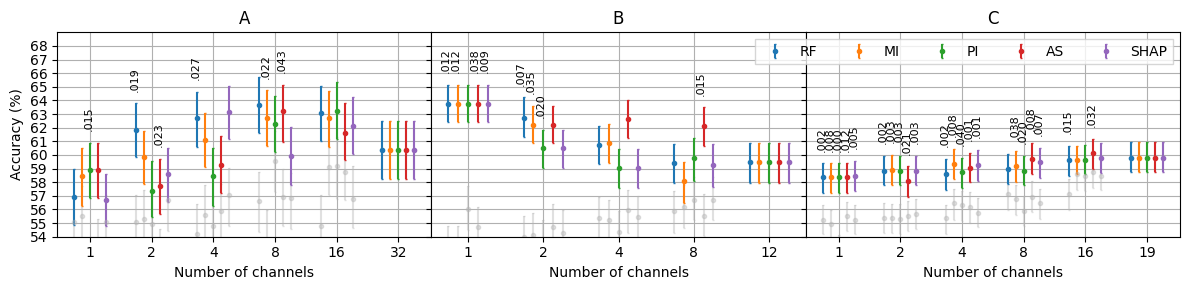

In [50]:

fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey='all')

for k, (ds, ds_name) in enumerate(zip(datasets, ds_names)):
    x_strs = [str(x_) for x_ in ds.num_channels_per_iteration]
    x = np.array([i for i in range(len(x_strs))])

    # Width of each error bar group
    bar_width = 0.13

    # Calculate the positions for each dataset
    pos_A = x - 2 * bar_width
    pos_B = x - bar_width
    pos_C = x
    pos_D = x + bar_width
    pos_E = x + 2 * bar_width

    positions = [pos_A, pos_B, pos_C, pos_D, pos_E]

    for idx, method in enumerate(methods_titles):

        worst_accs_list = avg_worst_accs[ds_name][method]
        ci_worst_upper_list = ci_worst_upper[ds_name][method]
        ci_worst_lower_list = ci_worst_lower[ds_name][method]

        best_accs_list = avg_best_accs[ds_name][method]
        ci_best_upper_list = ci_best_upper[ds_name][method]
        ci_best_lower_list = ci_best_lower[ds_name][method]

        max_chn = ds.num_channels_per_iteration[-1]

        signi_dict = {}
        signi_dict['baseline'] = {}
        signi_dict['max_chn'] = {}

        for j, num_chn in enumerate(ds.num_channels_per_iteration):
            m = titles_to_methods[method]
            _, _, accs_b, _, _ = conf_int_dict[ds_name][m][num_chn]["best"]
            _, _, accs_w, _, _ = conf_int_dict[ds_name][m][num_chn]["worst"]
            _, p_value = ttest_rel(accs_b, accs_w)
            signi_dict[num_chn] = p_value

        ax[k].errorbar(positions[idx], np.array(worst_accs_list),
                       yerr=(np.array(worst_accs_list)-np.array(ci_worst_lower_list), np.array(ci_worst_upper_list)-np.array(worst_accs_list)),
                       marker='o', linestyle='None', capsize=1, color=(0.7, 0.7, 0.7, 0.4), markersize=3)

        ax[k].errorbar(positions[idx], np.array(best_accs_list),
                     yerr=(np.array(best_accs_list) - np.array(ci_best_lower_list),
                           np.array(ci_best_upper_list) - np.array(best_accs_list)),
                     label=method, marker='o', linestyle='None', capsize=1, markersize=3)


        for j, num_chn in enumerate(ds.num_channels_per_iteration):
            significance_bl = signi_dict[num_chn]

            y_pos = ci_best_upper_list[j] + 0.01

            if significance_bl < 0.05:
                ax[k].text(positions[idx][j] - 0.1, y_pos, "{:.3f}".format(significance_bl)[1:], color="black", rotation="vertical", fontsize=8)

        # -----------

        min_ = 0.54
        max_ = 0.69
        y_ticks = [val for val in np.arange(min_, max_, 0.01)]
        y_strs = [int(100*val) for val in y_ticks]

        ax[k].set_xticks(x, x_strs)
        ax[k].set_yticks(y_ticks, y_strs)

        if k == 2:
            ax[k].legend(loc='upper right', fancybox=False, shadow=False, ncol=5)

        if k == 0:
            ax[k].set_ylabel("Accuracy (%)")

        ax[k].grid(True)
        ax[k].set_ylim(min_, max_)
        ax[k].set_title(ds_name)
        ax[k].set_xlabel("Number of channels")

if use_ica:
    ica_str ="_ICA"
else:
    ica_str = ""

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(os.path.join(path_shared_plots, f"lineplot_new_LDA_h{ica_str}.{file_format}"), bbox_inches='tight')
plt.show()


**Print n best channels per method for latex table**

In [51]:
n = 6

for idx, ds in enumerate(datasets):
    rankings = []
    methods = ['rf','mi','pi','shap', 'abl']
    row = "\\textbf{" + ds_names[idx] + "}"
    if idx == 0: row += r" & 1 & 2 & 3 & 4 & 5 & 6\\ \hline"
    else: row += r" &  &  &  &  & & \\ \hline"
    print(row)
    
    for m in methods:
        imp_path = os.path.join(ds.result_path, f"importances_{m}")
        electrodes = joblib.load(imp_path)
        chns = [(e,f) for e,f,s in electrodes]
        if m == "abl": m = "AS"
        else: m = m.upper()
        row = "\multicolumn{1}{l|}{" + m + "}"
        
        for ch in chns[:n]:
            ch_ = [ch[0], ch[1]]

            if ch_[1] == "upper gamma":
                ch_[1] = "gamma_2"
            elif ch[1] == "lower gamma":
                ch_[1] = "gamma_1"

            freq = " $\\" + ch_[1] + "$" if ch_[1] != "all" else ""
        
            row += " & " + ch_[0] + freq
        row += r" \\"
        print(row)

    print(r"\hline")
    print()

\textbf{A} & 1 & 2 & 3 & 4 & 5 & 6\\ \hline
\multicolumn{1}{l|}{RF} & P8 $\alpha$ & P4 $\alpha$ & O2 $\alpha$ & Oz $\alpha$ & P7 $\theta$ & CP6 $\alpha$ \\
\multicolumn{1}{l|}{MI} & P8 $\alpha$ & CP6 $\alpha$ & O2 $\alpha$ & FC1 $\alpha$ & F7 $\alpha$ & P4 $\alpha$ \\
\multicolumn{1}{l|}{PI} & P4 $\alpha$ & P3 $\beta$ & O1 $\theta$ & P8 $\alpha$ & Cz $\beta$ & F3 $\beta$ \\
\multicolumn{1}{l|}{SHAP} & P8 $\alpha$ & P7 $\theta$ & CP5 $\alpha$ & O1 $\theta$ & O2 $\alpha$ & P4 $\theta$ \\
\multicolumn{1}{l|}{AS} & F4 & Cz & CP5 & P4 & Oz & Fp2 \\
\hline

\textbf{B} &  &  &  &  & & \\ \hline
\multicolumn{1}{l|}{RF} & PO8 $\alpha$ & PO7 $\alpha$ & Fp2 $\alpha$ & Oz $\alpha$ & P4 $\theta$ & F3 $\alpha$ \\
\multicolumn{1}{l|}{MI} & PO8 $\alpha$ & PO7 $\alpha$ & Cz $\alpha$ & Fp2 $\alpha$ & F3 $\alpha$ & C3 $\alpha$ \\
\multicolumn{1}{l|}{PI} & PO8 $\alpha$ & PO7 $\alpha$ & Oz $\alpha$ & FT7 $\alpha$ & P4 $\beta$ & Fp2 $\alpha$ \\
\multicolumn{1}{l|}{SHAP} & PO8 $\alpha$ & P4 $\theta$ & PO7 $\

**Topographic Map**

<Figure size 640x480 with 0 Axes>

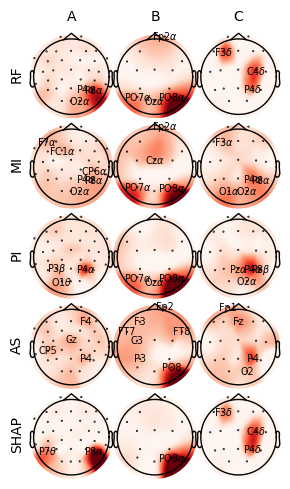

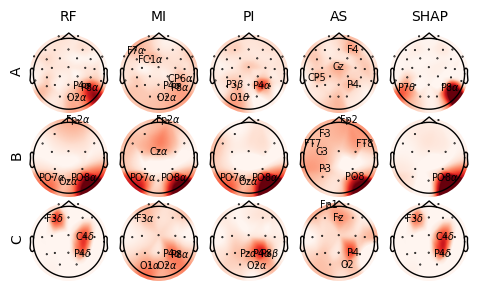

In [52]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

fig = plt.figure()
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

for h in [False, True]:
    if h:
        fig, ax = plt.subplots(num_ds, 5, figsize=(5, 3))
    else:
        fig, ax = plt.subplots(5, num_ds, figsize=(3, 5))

    fs = 10
    for idx, (ds, title) in enumerate(zip(datasets, ds_names)):
        evaluation.topo_plot_map(ax, ds, fs, idx=idx, norm="2", threshold=0.25, horizontal=h, contours=0)
        idx += 1

    fs = 10

    for i in range(num_ds):
        if h:
            ax[i][0].set_ylabel(ds_names[i], fontsize=fs, rotation=90)
        else:
            ax[0][i].set_title(ds_names[i], fontsize=fs)

    for i,m in enumerate(["RF", "MI", "PI", "AS", "SHAP"]):
        if h:
            ax[0][i].set_title(m, weight='normal', fontsize=fs)
        else:
            ax[i][0].set_ylabel(m, rotation=90, weight='normal', fontsize=fs)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.0, wspace=0.0)

    h_str = "h" if h else "v"
    plt.savefig(os.path.join(path_shared_plots, f"topo_{h_str}.{file_format}"))

    plt.show()

**Plot for Importances**

<Figure size 640x480 with 0 Axes>

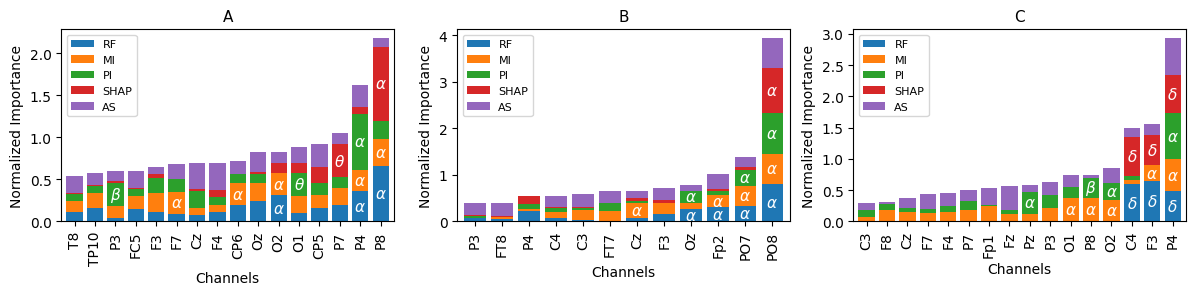

In [66]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)
plt.clf()

ylim = None

fs = 10

for horizontal in [True]: # , True]:
    
    if horizontal: 
        fig, axes = plt.subplots(1, num_ds, figsize=(4*num_ds, 3))
    else:
        fig, axes = plt.subplots(num_ds, 1, figsize=(4,3*num_ds))
        
    for idx, (ds,title) in enumerate(zip(datasets, ds_names)):
        
        if not horizontal:
            axes[idx].set_ylabel(title, fontsize=fs)
        else:
            axes[idx].set_title(title, fontsize=fs+1)
            axes[idx].set_ylabel("Normalized Importance", fontsize=fs)


        plt.rcParams['font.size'] = str(8)
        cols = evaluation.plot_importances_from_dataset(axes[idx], ds, file_format, width=0.8, ylim=ylim, num_chn=16, fontsize=11, norm="2", threshold=0.25)

        if horizontal:
            axes[idx].set_xlabel("Channels", fontsize=fs)

        axes[idx].legend(fontsize=8)

    h_str = "_h" if horizontal else "_v"
    plt.tight_layout()
    
    plt.savefig(os.path.join(path_shared_plots, f"barchart_stacked{h_str}.{file_format}"), bbox_inches='tight')
    plt.show()    

**Correlations**

(5, 32)
['RF', 'MI', 'PI', 'AS', 'SHAP']
(5, 12)
['RF', 'MI', 'PI', 'AS', 'SHAP']
(5, 19)
['RF', 'MI', 'PI', 'AS', 'SHAP']


<Figure size 640x480 with 0 Axes>

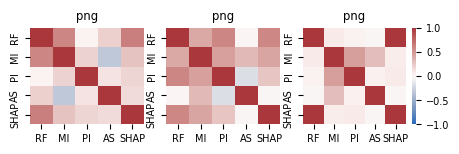

(5, 32)
['RF', 'MI', 'PI', 'AS', 'SHAP']
(5, 12)
['RF', 'MI', 'PI', 'AS', 'SHAP']
(5, 19)
['RF', 'MI', 'PI', 'AS', 'SHAP']


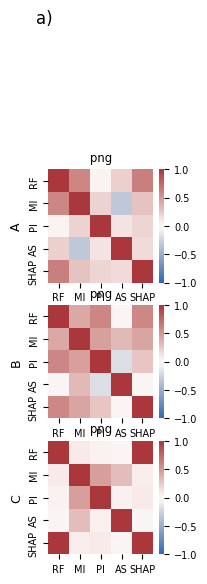

In [54]:
plt.clf()

for orientation in ["h", 'v']:

    if orientation == "h":
        fig, axes = plt.subplots(1,3, figsize=(5, 1.25))
        titles = ds_names
        h_str = "h"
    else: 
        fig, axes = plt.subplots(3,1, figsize=(1.5, 5))
        titles = [' ', ' ', ' ']
        h_str = "v"

    if orientation=="v":
        fig.suptitle("a)", y=1.2, x=0.1, fontsize=12)

    for idx, (ds, title) in enumerate(zip(datasets, titles)):
        ax = axes[idx]

        plt.rcParams['font.size'] = str(7)
        evaluation.correlation_rankings(ax, ds, file_format, idx=idx, horizontal=(orientation=='h'))
        idx += 1

    if orientation == "v":
        fs = 9
        for i in range(3):
            axes[i].set_ylabel(ds_names[i], weight = 'normal', fontsize = fs)    

    plt.savefig(os.path.join(path_shared_plots, f"corr_methods_{h_str}.{file_format}"), bbox_inches='tight')
    plt.show()

    

pi PI
abl AS
shap SHAP


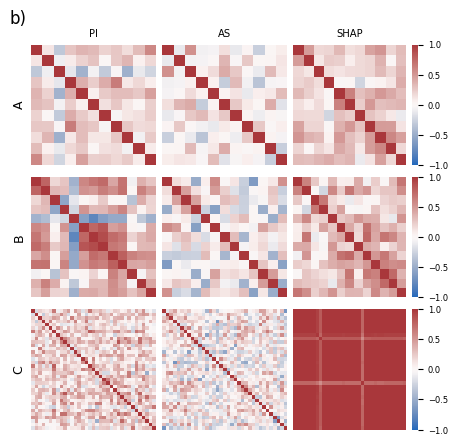

In [55]:
    
fig, axes = plt.subplots(3,3, figsize=(5,5))

titles = ds_names

fig.suptitle("b)", y=0.95, x=0.1, fontsize=12)

for idx, (ds, title) in enumerate(zip(datasets, titles)):

    ds = datasets[idx]
    ax = axes[idx]
    
    evaluation.correlation_rankings_folds(ax, ds, idx=idx)

    h_str = "_h" if horizontal else ""
    
plt.subplots_adjust(hspace=0.1, wspace=0.05)

fs = 9
for i in range(num_ds):
    axes[i][0].set_ylabel(titles[i], rotation = 90, weight = 'normal', fontsize = fs)    
    
plt.savefig(os.path.join(path_shared_plots, f"corr_folds{h_str}.{file_format}"), bbox_inches='tight')
plt.show()


In [56]:
dh = datasets[-1]
epochs_list = dh.get_epochs()


#             epochs_list.append((epochs, y, idx))

epoch = epochs_list[0][0]

print(epoch.plot(scalings))



NameError: name 'scalings' is not defined